In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob

import matplotlib.pyplot as plt
import data_processing_utils

## Overview
This script processes battery cell data from multiple batch folders, converting the raw `.csv` file format into a structured nested-dictionary format. 

The restructuring enables efficient iteration and feature engineering on the parsed time-series data for each cycle. Each cycle is represented as a nested dictionary, with the cycle number serving as a key at the second level of the hierarchy. We also include summary information for each cell. This format facilitates detailed analysis and modeling of battery performance metrics, performed at the other .ipynb files.

In [ ]:
# Define the path to the data folder
data_folder_list = ['Batch-1', 'Batch-2']
pickleDict = dict()

# Iterate through each folder and load .mat files into pickleDict
for folder in data_folder_list:
    # Get a list of all files in the data folder
    files = glob.glob(os.path.join('data', folder, '*'))

    # Iterate over the list of files and read them
    for file in files:
        file_name = os.path.basename(file)
        with open(file, 'rb') as f:
            pickleDict[file_name.split('.')[0]] = scipy.io.loadmat(f)

In [ ]:
# Initialize saveDict to store processed data
saveDict = dict()

# Process each key in pickleDict
for key in pickleDict.keys():
    saveDict[key] = dict()
    chargetimeArr = np.array([])  # Array to store charge times
    TmaxArr = np.array([])        # Array to store max temperatures
    TminArr = np.array([])        # Array to store min temperatures
    saveDict[key]['cycles'] = dict()
    
    # Iterate through each cycle in the data
    for cycle in range(pickleDict[key]['data'][0].shape[0]):
        saveDict[key]['cycles'][str(cycle)] = dict()\
            
        # Extract and reshape data for the current cycle
        saveDict[key]['cycles'][str(cycle)]['t_relative'] = pickleDict[key]['data'][0][cycle][1].reshape(1, -1)[0]
        saveDict[key]['cycles'][str(cycle)]['V'] = pickleDict[key]['data'][0][cycle][2].reshape(1, -1)[0]
        saveDict[key]['cycles'][str(cycle)]['I'] = pickleDict[key]['data'][0][cycle][3].reshape(1, -1)[0]
        saveDict[key]['cycles'][str(cycle)]['Q'] = pickleDict[key]['data'][0][cycle][4].reshape(1, -1)[0]
        saveDict[key]['cycles'][str(cycle)]['W'] = pickleDict[key]['data'][0][cycle][5].reshape(1, -1)[0]
        saveDict[key]['cycles'][str(cycle)]['T_cell'] = pickleDict[key]['data'][0][cycle][6].reshape(1, -1)[0]
        
        # Adjust time array to handle discontinuities
        t = saveDict[key]['cycles'][str(cycle)]['t_relative'].copy()
        for idx in np.argwhere(np.diff(t) < -0.2)[::-1]: 
            t[idx.item()+1:] += t[idx.item()]
        saveDict[key]['cycles'][str(cycle)]['t'] = t
        
        # Identify indices for charge, discharge, and rest phases
        idxCh = np.argwhere(saveDict[key]['cycles'][str(cycle)]['I'] > 0.05).reshape(1, -1)[0]
        idxDis = np.argwhere(saveDict[key]['cycles'][str(cycle)]['I'] < -0.05).reshape(1, -1)[0]
        idxRest = np.argwhere((saveDict[key]['cycles'][str(cycle)]['I'] <= 0.05) & (saveDict[key]['cycles'][str(cycle)]['I'] >= -0.05)).reshape(1, -1)[0]
        try:
            # Separate rest indices into charge and discharge phases
            idxRestDis = idxRest[np.argwhere(np.diff(idxRest)>1)[-1].item()+1:]
            idxRestCh = idxRest[:np.argwhere(np.diff(idxRest)>1)[-1].item()+1]
        except: idxRestCh = idxRestDis = idxRest
        
        # Ensure the sum of indices matches the total length
        assert(len(saveDict[key]['cycles'][str(cycle)]['I']) == (len(idxCh) + len(idxDis) + len(idxRest)))
        
        # Create step_index to label different cycling segments: charger, discharge, and rest periods
        saveDict[key]['cycles'][str(cycle)]['Step_index'] = np.ones(len(saveDict[key]['cycles'][str(cycle)]['T_cell']))
        saveDict[key]['cycles'][str(cycle)]['Step_index'][idxCh] = [0] * len(idxCh)
        saveDict[key]['cycles'][str(cycle)]['Step_index'][idxDis] = [2] * len(idxDis)
        saveDict[key]['cycles'][str(cycle)]['Step_index'][idxRestDis] = [3] * len(idxRestDis)
        saveDict[key]['cycles'][str(cycle)]['Step_index'][idxRestCh] = [1] * len(idxRestCh)
        
        # Separate charge and discharge capacities
        saveDict[key]['cycles'][str(cycle)]['Qc'] = np.zeros(len(saveDict[key]['cycles'][str(cycle)]['T_cell']))
        saveDict[key]['cycles'][str(cycle)]['Qc'][idxCh] = saveDict[key]['cycles'][str(cycle)]['Q'][idxCh]
        saveDict[key]['cycles'][str(cycle)]['Qd'] = np.zeros(len(saveDict[key]['cycles'][str(cycle)]['T_cell']))
        saveDict[key]['cycles'][str(cycle)]['Qd'][idxDis] = saveDict[key]['cycles'][str(cycle)]['Q'][idxDis]
        
        # Linearize voltage and temperature data for charge and discharge phases
        saveDict[key]['cycles'][str(cycle)]['Vc_lin'], saveDict[key]['cycles'][str(cycle)]['Tc_lin'] = data_processing_utils.interpolate_data(
            xp=saveDict[key]['cycles'][str(cycle)]['V'][idxCh], stepInstance=0.005, 
            fp=saveDict[key]['cycles'][str(cycle)]['T_cell'][idxCh], xLimitList=[3.6, 4.195])
        saveDict[key]['cycles'][str(cycle)]['Vd_lin'], saveDict[key]['cycles'][str(cycle)]['Td_lin'] = data_processing_utils.interpolate_data(
            xp=saveDict[key]['cycles'][str(cycle)]['V'][idxDis], stepInstance=0.01, 
            fp=saveDict[key]['cycles'][str(cycle)]['T_cell'][idxDis], xLimitList=[4.15, 2.5])
        _, saveDict[key]['cycles'][str(cycle)]['Qc_lin'] = data_processing_utils.interpolate_data(
            xp=saveDict[key]['cycles'][str(cycle)]['V'][idxCh], stepInstance=0.005, 
            fp=saveDict[key]['cycles'][str(cycle)]['Qc'][idxCh], xLimitList=[3.6, 4.2])
        _, saveDict[key]['cycles'][str(cycle)]['Qd_lin'] = data_processing_utils.interpolate_data(
            xp=saveDict[key]['cycles'][str(cycle)]['V'][idxDis], stepInstance=0.01, 
            fp=saveDict[key]['cycles'][str(cycle)]['Qd'][idxDis], xLimitList=[4.15, 2.49])       
        
        # Append charge time, max temperature, and min temperature for the current cycle
        chargetimeArr = np.append(chargetimeArr, np.max(saveDict[key]['cycles'][str(cycle)]['t_relative'][idxCh]))
        TmaxArr = np.append(TmaxArr, np.max(saveDict[key]['cycles'][str(cycle)]['T_cell']))
        TminArr = np.append(TminArr, np.min(saveDict[key]['cycles'][str(cycle)]['T_cell']))
        
    # Add summary information across all cycles for each file
    saveDict[key]['summary'] = dict()
    saveDict[key]['summary']['cycle'] = np.arange(0, len(pickleDict[key]['summary'][0][0][0]))
    saveDict[key]['summary']['Qc'] = pickleDict[key]['summary'][0][0][0]
    saveDict[key]['summary']['Qd'] = pickleDict[key]['summary'][0][0][1]
    saveDict[key]['summary']['Wc'] = pickleDict[key]['summary'][0][0][2]
    saveDict[key]['summary']['Wd'] = pickleDict[key]['summary'][0][0][3]
    saveDict[key]['summary']['Vc_median'] = pickleDict[key]['summary'][0][0][4]
    saveDict[key]['summary']['Vd_median'] = pickleDict[key]['summary'][0][0][5]
    saveDict[key]['summary']['Vc_mean'] = pickleDict[key]['summary'][0][0][6]
    saveDict[key]['summary']['Vd_mean'] = pickleDict[key]['summary'][0][0][7]
    saveDict[key]['summary']['chargetime'] = chargetimeArr
    saveDict[key]['summary']['IRavg'] = np.ones(len(pickleDict[key]['summary'][0][0][0]))
    saveDict[key]['summary']['Tmax'] = TmaxArr
    saveDict[key]['summary']['Tmin'] = TminArr
    
    # Add cycle life as model's target
    saveDict[key]['cycleLife'] = pickleDict[key]['summary'][0][0][8]

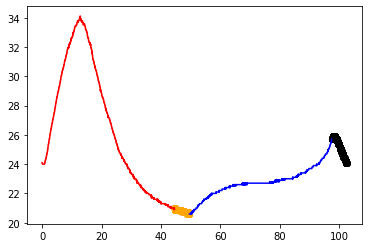

In [ ]:
# Random check on continuity the different index-splitting based on the extracted Step_index
plt.plot(saveDict[key]['cycles'][str(cycle)]['t'][idxCh], saveDict[key]['cycles'][str(cycle)]['T_cell'][idxCh], color = 'red')
plt.plot(saveDict[key]['cycles'][str(cycle)]['t'][idxDis], saveDict[key]['cycles'][str(cycle)]['T_cell'][idxDis], color = 'blue')
plt.scatter(saveDict[key]['cycles'][str(cycle)]['t'][idxRestCh], saveDict[key]['cycles'][str(cycle)]['T_cell'][idxRestCh], color = 'orange')
plt.scatter(saveDict[key]['cycles'][str(cycle)]['t'][idxRestDis], saveDict[key]['cycles'][str(cycle)]['T_cell'][idxRestDis], color = 'black')

In [ ]:
# Save the processed data to a .npy file
np.save('batteryDictionary', saveDict)